In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

# Deep Learning
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten, BatchNormalization, Convolution2D , MaxPooling2D
from keras import  backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing import image

# k-NN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Image
from PIL import Image

pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
train = pd.read_csv('./train.csv', encoding='utf8')
test = pd.read_csv('./test.csv', encoding='utf8')
train_column_headers = list(train.columns.values)[1:]

# Analisis Exploratorio

In [3]:
exploratory = train.copy()
threshold = 15

for column in train_column_headers:
  exploratory.loc[exploratory[column] < threshold, column] = 0
  exploratory.loc[exploratory[column] >= threshold, column] = 1

In [4]:
# Cantidad de pixeles oscuros vs claros
train.head(1).transpose().value_counts()

0      687
253     24
254      6
94       3
93       3
240      2
209      2
89       2
80       2
191      2
188      2
248      2
20       2
250      2
13       2
7        2
245      1
208      1
195      1
196      1
198      1
203      1
206      1
207      1
251      1
247      1
210      1
214      1
220      1
235      1
238      1
218      1
167      1
170      1
54       1
10       1
15       1
16       1
17       1
22       1
23       1
25       1
27       1
29       1
76       1
168      1
77       1
81       1
88       1
95       1
103      1
123      1
131      1
159      1
1        1
255      1
dtype: int64

In [5]:
x_train = (exploratory.iloc[:,1:].values).astype('float32')
y_train = exploratory.iloc[:,0].values.astype('int32')

Text(0.5, 1.0, '0')

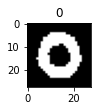

In [6]:
# Convertir dataset a (numero de imagenes, pixeles ancho, pixeles largo) 
x_train = x_train.reshape(x_train.shape[0], 28, 28)

plt.subplot(331)
plt.imshow(x_train[1], cmap=plt.get_cmap('gray'))
plt.title(y_train[1])

In [7]:
# Se encuentran cuantos pixels blancos hay en cada imagen
exploratory = exploratory.astype('int32')

pixels = exploratory.sum(axis=1)
white_pixels = pd.DataFrame(data={'label': exploratory['label'], 'pixels': pixels})
white_pixels.groupby(by='label').describe()

pixels                                                         
        count        mean        std   min    25%    50%    75%    max
label                                                                 
0      4132.0  182.751210  34.021410  81.0  159.0  181.0  204.0  350.0
1      4684.0   82.848847  19.350918  35.0   69.0   81.0   94.0  200.0
2      4177.0  162.291836  32.598162  70.0  139.0  162.0  184.0  299.0
3      4351.0  157.356240  33.233060  58.0  134.0  156.0  180.0  281.0
4      4072.0  137.650295  27.374384  66.0  117.0  135.0  156.0  259.0
5      3795.0  148.838735  33.353158  60.0  125.0  147.0  171.0  292.0
6      4137.0  155.499637  32.091746  59.0  133.0  153.0  176.0  296.0
7      4401.0  131.479209  26.568002  69.0  112.0  129.0  149.0  251.0
8      4063.0  171.935516  32.470633  84.0  149.0  169.0  191.0  303.0
9      4188.0  144.050143  27.935318  73.0  125.0  142.0  161.0  272.0

In [8]:
white_pixels['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

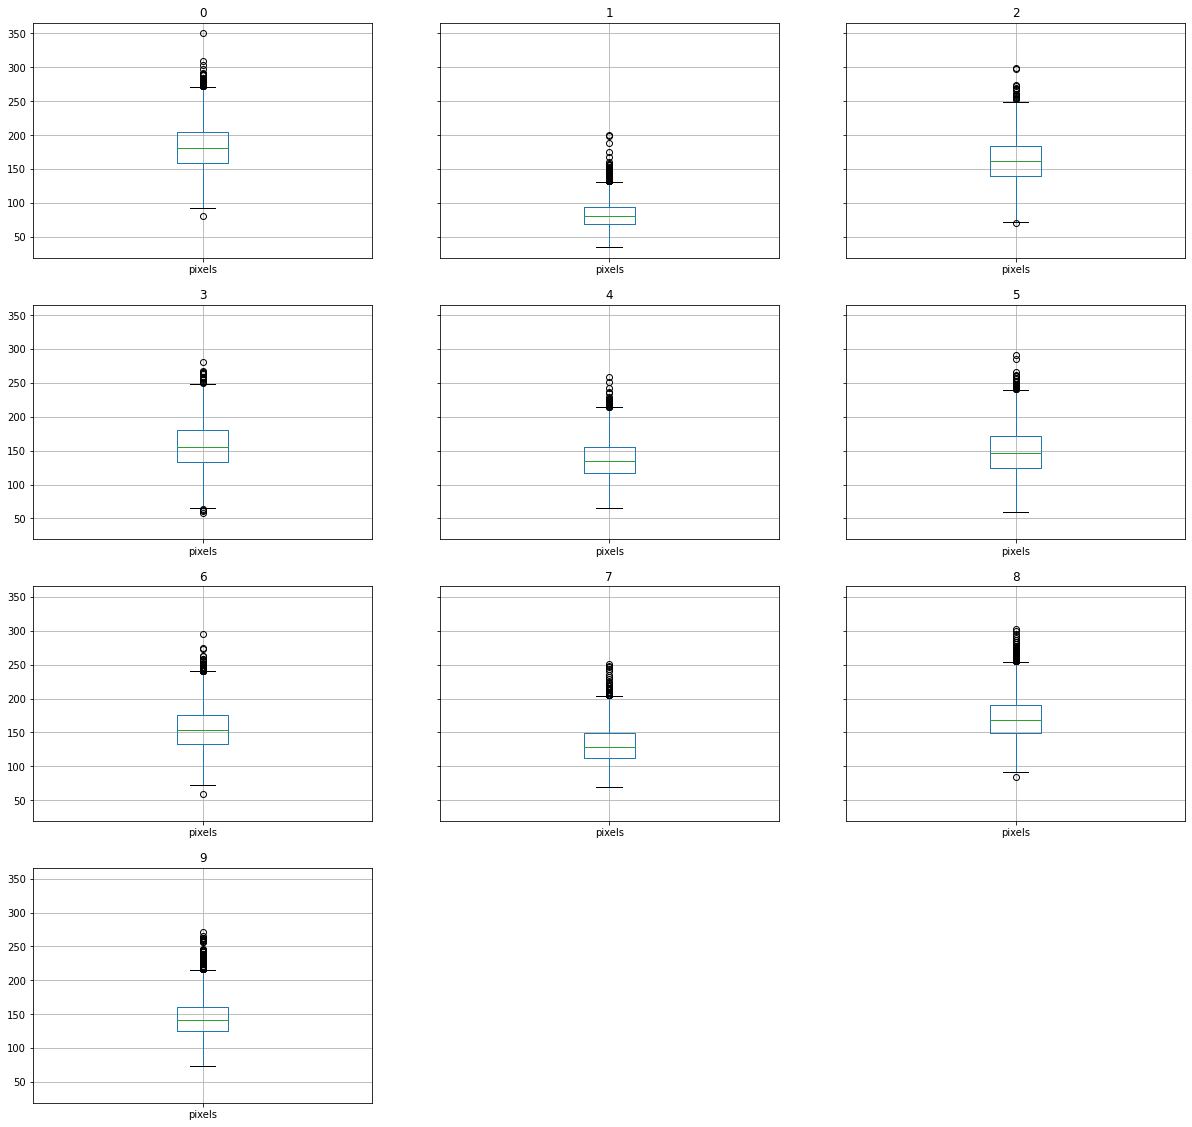

In [9]:
plt.rcParams["figure.figsize"] = (20, 20)
white_pixels.groupby(by='label').boxplot(column='pixels')
plt.rcParams["figure.figsize"] = (6, 4)

# Redes Neuronales

In [10]:
x_train = (train.iloc[:,1:].values).astype('float32')
y_train = train.iloc[:,0].values.astype('int32')
x_test = test.values.astype('float32')

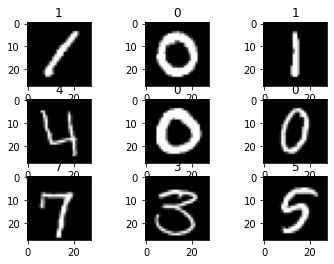

In [11]:
#Convert train datset to (num_images, img_rows, img_cols) format 
x_train = x_train.reshape(x_train.shape[0], 28, 28)

for i in range(0, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])

In [12]:
x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_train.shape

(42000, 28, 28, 1)

In [13]:
x_test = x_test.reshape(x_test.shape[0], 28, 28,1)
x_test.shape

(28000, 28, 28, 1)

In [14]:
mean_px = x_train.mean().astype(np.float32)
std_px = x_train.std().astype(np.float32)

def standardize(x): 
  return (x-mean_px)/std_px

In [15]:
y_train = to_categorical(y_train)
num_classes = y_train.shape[1]
num_classes

10

In [16]:
seed = 43
np.random.seed(seed)

In [17]:
model = Sequential()
model.add(Lambda(standardize, input_shape=(28,28,1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
print('input shape', model.input_shape)
print('output shape', model.output_shape)

input shape (None, 28, 28, 1)
output shape (None, 10)


In [18]:
model.compile(
  optimizer='rmsprop',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)
gen = image.ImageDataGenerator()

In [19]:
x = x_train
y = y_train
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

In [20]:
history=model.fit(
  x=x_train,
  y=y_train,
  epochs=6,
  batch_size=16,
  validation_split=0.1,
  verbose=2
)

Epoch 1/6
1890/1890 - 3s - loss: 0.4118 - accuracy: 0.8777 - val_loss: 0.3181 - val_accuracy: 0.9131 - 3s/epoch - 1ms/step
Epoch 2/6
1890/1890 - 2s - loss: 0.3183 - accuracy: 0.9105 - val_loss: 0.3008 - val_accuracy: 0.9235 - 2s/epoch - 1ms/step
Epoch 3/6
1890/1890 - 2s - loss: 0.3041 - accuracy: 0.9174 - val_loss: 0.3207 - val_accuracy: 0.9208 - 2s/epoch - 1ms/step
Epoch 4/6
1890/1890 - 2s - loss: 0.2971 - accuracy: 0.9175 - val_loss: 0.3220 - val_accuracy: 0.9199 - 2s/epoch - 1ms/step
Epoch 5/6
1890/1890 - 2s - loss: 0.2910 - accuracy: 0.9209 - val_loss: 0.3165 - val_accuracy: 0.9226 - 2s/epoch - 1ms/step
Epoch 6/6
1890/1890 - 2s - loss: 0.2859 - accuracy: 0.9230 - val_loss: 0.3108 - val_accuracy: 0.9289 - 2s/epoch - 1ms/step


In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

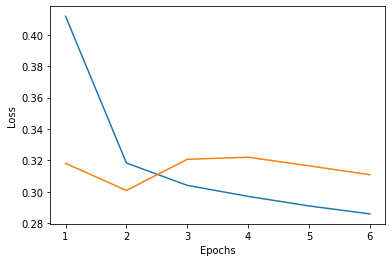

In [22]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values)
plt.plot(epochs, val_loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

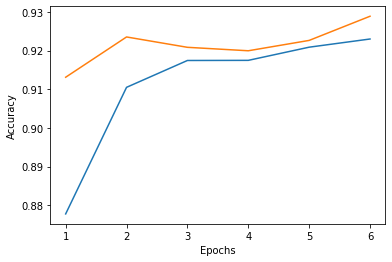

In [23]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values)
plt.plot(epochs, val_acc_values)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [24]:
y_preds = model.predict(x_val, verbose=0)

In [25]:
y_prediction = []
for prediction in y_preds:
  max_value = max(prediction)
  max_index = list(prediction).index(max_value)
  y_prediction.append(max_index)
y_prediction = np.array(y_prediction).astype('int64')

In [26]:
y_validation = []
for value in y_val:
  max_value = max(value)
  max_index = list(value).index(max_value)
  y_validation.append(max_index)
y_validation = np.array(y_validation).astype('int64')

In [27]:
result = confusion_matrix(y_validation, y_prediction)
result

array([[792,   0,   1,   2,   4,  10,   3,   1,   2,   1],
       [  0, 885,   6,   1,   1,   4,   1,   2,   8,   1],
       [  9,   6, 763,  13,  16,   7,   6,  10,  14,   2],
       [  1,   3,  17, 832,   0,  42,   5,   6,  16,  15],
       [  2,   1,   5,   1, 792,   2,   7,   2,   2,  25],
       [  8,   1,   8,  22,  10, 622,  14,   3,  11,   3],
       [  6,   1,  12,   0,  11,  12, 737,   1,   5,   0],
       [  1,   3,  16,   7,  15,   5,   0, 812,   2,  32],
       [  4,   9,  10,  26,   7,  42,   6,   1, 722,   8],
       [  5,   4,   5,  12,  30,  12,   0,  26,   4, 740]], dtype=int64)

In [28]:
accuracy = metrics.accuracy_score(y_validation, y_prediction)
accuracy

0.9163095238095238

# Deep Learning

In [95]:
x_train = (train.iloc[:,1:].values).astype('float32')
y_train = train.iloc[:,0].values.astype('int32')
x_test = test.values.astype('float32')

x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28,1)

y_train = to_categorical(y_train)
num_classes = y_train.shape[1]

seed = 43
np.random.seed(seed)

In [30]:
modelo = Sequential()
#Agregamos la primera convolución
modelo.add(Convolution2D(32,(3,3),strides=(1,1), input_shape=(28,28,1), activation='relu'))

In [31]:
modelo.add(MaxPooling2D(pool_size=(2,2)))

In [32]:
modelo.add(Convolution2D(64,(3,3),strides=(1,1),activation='relu'))
modelo.add(MaxPooling2D(pool_size=(2,2)))

In [33]:
modelo.add(Flatten())

In [34]:
modelo.add(Dense(512,activation='relu'))

In [35]:
modelo.add(Dense(10, activation='sigmoid'))

In [36]:
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_1 (Dense)             (None, 512)              

In [37]:
modelo.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')

In [38]:
epocas = 3
lote = 32

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

In [39]:
H = modelo.fit(
  x=x_train,
  y=y_train,
  epochs=epocas
)

Epoch 1/3
1050/1050 [==============================] - 16s 14ms/step - loss: 0.0790 - accuracy: 0.9522
Epoch 2/3
1050/1050 [==============================] - 15s 14ms/step - loss: 0.0118 - accuracy: 0.9852
Epoch 3/3
1050/1050 [==============================] - 15s 14ms/step - loss: 0.0079 - accuracy: 0.9904


In [40]:
y_preds = modelo.predict(x_val)

263/263 [==============================] - 1s 4ms/step


In [41]:
len(x_test)

28000

In [42]:
len(y_preds)

8400

In [43]:
y_prediction = []
for prediction in y_preds:
  max_value = max(prediction)
  max_index = list(prediction).index(max_value)
  y_prediction.append(max_index)
y_prediction = np.array(y_prediction).astype('int64')

In [44]:
y_validation = []
for value in y_val:
  max_value = max(value)
  max_index = list(value).index(max_value)
  y_validation.append(max_index)
y_validation = np.array(y_validation).astype('int64')

In [45]:
result = confusion_matrix(y_validation, y_prediction)
result

array([[798,   0,   2,   0,   1,   1,  11,   1,   1,   1],
       [  0, 906,   2,   0,   0,   0,   1,   0,   0,   0],
       [  1,   3, 835,   1,   2,   0,   0,   1,   3,   0],
       [  0,   0,   4, 919,   0,   7,   0,   1,   5,   1],
       [  0,   0,   1,   0, 827,   0,   4,   3,   0,   4],
       [  0,   0,   0,   3,   1, 697,   0,   0,   0,   1],
       [  0,   2,   0,   0,   0,   2, 779,   0,   2,   0],
       [  0,   5,   6,   2,   0,   0,   0, 879,   1,   0],
       [  1,   2,   1,   0,   3,   5,   1,   1, 821,   0],
       [  1,   1,   1,   2,  17,   2,   0,   4,   3, 807]], dtype=int64)

In [46]:
accuracy = metrics.accuracy_score(y_validation, y_prediction)
accuracy

0.9842857142857143

# k-NN

In [47]:
target_knn = train['label']
train_knn = train.drop('label', axis=1)

In [48]:
x_train_knn, x_val_knn, y_train_knn, y_val_knn = train_test_split(train_knn, target_knn, test_size=0.20, random_state=42)

In [49]:
model_knn = KNeighborsClassifier()
model_knn.fit(x_train_knn, y_train_knn)
y_preds_knn = model_knn.predict(x_val_knn)

In [50]:
y_preds_knn

array([8, 1, 9, ..., 3, 0, 9], dtype=int64)

In [51]:
y_val_knn.values

array([8, 1, 9, ..., 3, 0, 9], dtype=int64)

In [52]:
result = confusion_matrix(y_val_knn.values, y_preds_knn)
result

array([[812,   0,   0,   0,   0,   0,   4,   0,   0,   0],
       [  0, 906,   0,   0,   0,   0,   3,   0,   0,   0],
       [  6,  15, 796,   3,   2,   2,   1,  20,   1,   0],
       [  2,   4,   4, 900,   0,   9,   1,   6,   5,   6],
       [  1,   5,   0,   0, 811,   0,   3,   1,   0,  18],
       [  1,   2,   0,  15,   1, 669,   9,   0,   1,   4],
       [  5,   0,   0,   0,   0,   3, 777,   0,   0,   0],
       [  0,  18,   2,   0,   1,   0,   0, 857,   0,  15],
       [  1,  12,   2,  12,   3,  15,   4,   1, 777,   8],
       [  3,   3,   1,  10,   6,   1,   0,  12,   2, 800]], dtype=int64)

In [53]:
accuracy_knn = metrics.accuracy_score(y_val_knn.values, y_preds_knn)
accuracy_knn

0.9648809523809524

# Own Images

In [54]:
images = []
for i in range(1, 11):
  images.append(Image.open('./imagenes/img' + str(i) + '.png'))
len(images)

10

In [101]:
pixels = []
for image in images:
  # Adds the answer
  image_pixels = []

  # Iterates the image
  for i in range (0, 28):
    for j in range(0, 28):
      # pixel = 1 if image.getpixel((i, j))[0] > 15 else 0
      pixel = image.getpixel((j, i))[0]
      image_pixels.append(pixel)
  
  # Adds image pixels
  pixels.append(image_pixels)
columns = ['pixel' + str(x) for x in range(784)]

In [102]:
test_io = pd.DataFrame(data=pixels, columns=columns)
test_io

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel

In [103]:
y_val_oi = np.array([3, 2, 7, 7, 9, 0, 1, 5, 4, 6])
y_val_oi

array([3, 2, 7, 7, 9, 0, 1, 5, 4, 6])

In [104]:
x_val_oi = (test_io.values).astype('float32')
x_val_oi = x_val_oi.reshape(x_val_oi.shape[0], 28, 28,1)

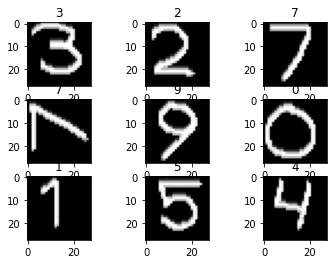

In [112]:
for i in range(0, 9):
  plt.subplot(330 + (i+1))
  plt.imshow(x_val_oi[i], cmap=plt.get_cmap('gray'))
  plt.title(y_val_oi[i])

In [106]:
y_preds_io = modelo.predict(x_val_oi)

1/1 [==============================] - 0s 20ms/step


In [107]:
y_prediction_io = []
for prediction in y_preds_io:
  max_value = max(prediction)
  max_index = list(prediction).index(max_value)
  y_prediction_io.append(max_index)
y_prediction_io = np.array(y_prediction_io).astype('int64')
y_prediction_io

array([3, 2, 2, 7, 4, 0, 1, 5, 4, 0], dtype=int64)

In [108]:
result = confusion_matrix(y_val_oi, y_prediction_io)
result

array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0]], dtype=int64)

In [109]:
accuracy = metrics.accuracy_score(y_val_oi, y_prediction_io)
accuracy

0.7